In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_data_frequency_conversor as dfc
import my_models as mm
import my_llm_ts_preprocessor as tsp
#import my_prompting_tool as mpt 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

from nixtla import NixtlaClient
from dotenv import load_dotenv
import os

load_dotenv()  # Carga el .env

from itertools import islice
import matplotlib.dates as mdates
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset

import sys
from types import ModuleType

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split


In [2]:
DATA_HOURS = 'DATA/ETHUSD-H1.csv'
DATA_DAYS = 'DATA/ETHUSD-D1.csv'
DATA_MONTHS = 'DATA/ETHUSD-Monthly.csv'
arima_h = mm.Model('ARIMA')
arima_d = mm.Model('ARIMA-d')
arima_m = mm.Model('ARIMA-m')
exp_smooth_h = mm.Model('EXPONENTIAL SMOOTHING')
exp_smooth_d = mm.Model('EXPONENTIAL SMOOTHING')
exp_smooth_m = mm.Model('EXPONENTIAL SMOOTHING')
holt_h = mm.Model('HOLT')
holt_d = mm.Model('HOLT')
holt_m = mm.Model('HOLT')
holt_winters_h = mm.Model('HOLT WINTERS')
holt_winters_d = mm.Model('HOLT WINTERS')
holt_winters_m = mm.Model('HOLT WINTERS')
timegpt_h = mm.Model('TIMEGPT')
timegpt_d = mm.Model('TIMEGPT')
timegpt_m = mm.Model('TIMEGPT')
lagllama_h = mm.Model('LAGLLAMA')
lagllama_d = mm.Model('LAGLLAMA')
lagllama_m = mm.Model('LAGLLAMA')
gpt_h = mm.Model('GPT-H')
gpt_d = mm.Model('GPT-D')
gpt_m = mm.Model('GPT-M')


In [3]:
df = pd.read_csv(DATA_HOURS, delimiter=',')
train_data_hours, val_data_hours = dfc.split_data(df)
train_data_hours = train_data_hours.asfreq('h')
val_data_hours = val_data_hours.asfreq('h')
print(train_data_hours.head())
print(val_data_hours.head())

                          y
DateTime                   
2017-01-01 00:00:00  8.0441
2017-01-01 01:00:00  8.1990
2017-01-01 02:00:00  8.2600
2017-01-01 03:00:00  8.4230
2017-01-01 04:00:00  8.5700
                          y
DateTime                   
2024-01-01 00:00:00  2286.5
2024-01-01 01:00:00  2295.6
2024-01-01 02:00:00  2305.4
2024-01-01 03:00:00  2295.8
2024-01-01 04:00:00  2275.4


In [ ]:
# Crear una serie de ejemplo
series = [0.123, 1.23, 12.3, 123.0, 1000.0]

# Instanciar el preprocesador
preprocessor = tsp.TimeSeriesPreprocessor(percentile=95)

# Procesar la serie
processed_series = preprocessor.preprocess(series)

print(processed_series)


In [4]:
df = pd.read_csv(DATA_DAYS, delimiter=',')
train_data_days, val_data_days = dfc.split_data(df)
train_data_days = train_data_days.asfreq('d')
val_data_days = val_data_days.asfreq('d')
print(train_data_days.head())
print(val_data_days.head())

                  y
DateTime           
2017-01-01   8.0441
2017-01-02   8.2200
2017-01-03   8.3700
2017-01-04   9.6620
2017-01-05  11.0620
                 y
DateTime          
2024-01-01  2286.5
2024-01-02  2352.7
2024-01-03  2358.2
2024-01-04  2211.3
2024-01-05  2271.0


In [6]:
data_months = pd.read_csv(DATA_MONTHS, delimiter=',')
train_data_months, val_data_months = dfc.split_data(data_months)
train_data_months = train_data_months.asfreq('MS')
val_data_months = val_data_months.asfreq('MS')
print(train_data_months.head())
print(val_data_months.head())

                  y
DateTime           
2017-01-01   8.0441
2017-02-01  10.7110
2017-03-01  15.8300
2017-04-01  49.7770
2017-05-01  83.5180
                 y
DateTime          
2024-01-01  2286.5
2024-02-01  2283.0
2024-03-01  3339.2
2024-04-01  3650.6
2024-05-01  3020.3


In [7]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

C:\Users\vicde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Convertir la serie en DataFrame con las columnas correctas
arima_m.nixtla_format = dfc.convert_to_nixtla(train_data_months)
print(arima_m.nixtla_format.head())
arima_m.model = StatsForecast(
    models=[AutoARIMA(season_length=1)],
    freq='MS'
)

arima_m.model.fit(arima_m.nixtla_format)
arima_m.forecast = arima_m.model.predict(h=12, level=[95])
print(arima_m.forecast)

          ds        y unique_id
0 2017-01-01   8.0441     Value
1 2017-02-01  10.7110     Value
2 2017-03-01  15.8300     Value
3 2017-04-01  49.7770     Value
4 2017-05-01  83.5180     Value
   unique_id         ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0      Value 2024-01-01  2118.434494      1459.715885      2777.153102
1      Value 2024-02-01  2068.879419      1048.524667      3089.234171
2      Value 2024-03-01  2106.237361       875.386223      3337.088500
3      Value 2024-04-01  2078.074436       633.132789      3523.016084
4      Value 2024-05-01  2099.305540       491.443124      3707.167956
5      Value 2024-06-01  2083.300108       311.575957      3855.024260
6      Value 2024-07-01  2095.366077       184.874714      4005.857441
7      Value 2024-08-01  2086.269940        38.572595      4133.967285
8      Value 2024-09-01  2093.127219       -77.552234      4263.806673
9      Value 2024-10-01  2087.957742      -203.090765      4379.006248
10     Value 2024-11-01  20

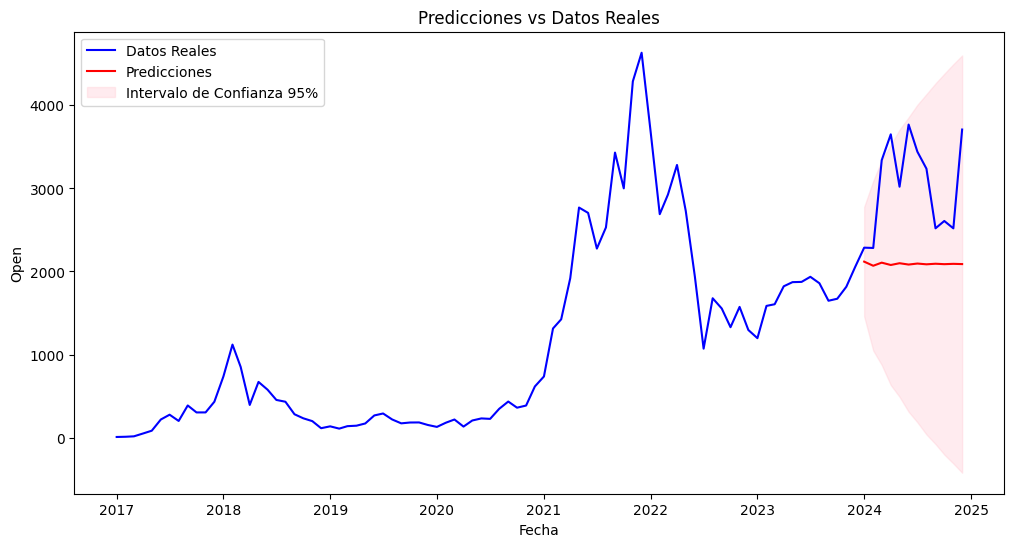

In [9]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_months.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_months.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
val_df.columns = ['ds', 'y']  # Renombrar columnas
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_m.forecast['ds'], arima_m.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_m.forecast['ds'],
    arima_m.forecast['AutoARIMA-lo-95'],
    arima_m.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Open')

# Mostrar la gráfica
plt.show()

In [10]:
arima_d.nixtla_format = dfc.convert_to_nixtla(train_data_days)
print(arima_d.nixtla_format.head())
arima_d.model = StatsForecast(
    models=[AutoARIMA(season_length=1)],
    freq='D'
)
'''
season_length=7:Se asume que hay un patrón semanal en los datos diarios. 
Si no es el caso, puedes cambiarlo a 1 (sin estacionalidad) o 365 (estacionalidad anual).
'''
arima_d.model.fit(arima_d.nixtla_format)
arima_d.forecast = arima_d.model.predict(h=366, level=[95])
print(arima_d.forecast)

          ds        y unique_id
0 2017-01-01   8.0441     Value
1 2017-01-02   8.2200     Value
2 2017-01-03   8.3700     Value
3 2017-01-04   9.6620     Value
4 2017-01-05  11.0620     Value
    unique_id         ds    AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0       Value 2024-01-01  2291.784091      2154.248884      2429.319299
1       Value 2024-01-02  2283.363944      2095.214554      2471.513333
2       Value 2024-01-03  2289.051766      2059.372917      2518.730615
3       Value 2024-01-04  2293.848950      2025.794967      2561.902933
4       Value 2024-01-05  2286.753237      1987.780438      2585.726037
..        ...        ...          ...              ...              ...
361     Value 2024-12-27  2288.983658      -246.677695      4824.645010
362     Value 2024-12-28  2288.983658      -250.177414      4828.144730
363     Value 2024-12-29  2288.983658      -253.672316      4831.639632
364     Value 2024-12-30  2288.983658      -257.162421      4835.129737
365     Value 20

In [ ]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_days.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_days.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
val_df.columns = ['ds', 'y']  # Renombrar columnas
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_d.forecast['ds'], arima_d.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_d.forecast['ds'],
    arima_d.forecast['AutoARIMA-lo-95'],
    arima_d.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Open')

# Mostrar la gráfica
plt.show()

In [ ]:
arima_h.nixtla_format = dfc.convert_to_nixtla(train_data_hours)
print(arima_h.nixtla_format.head())
arima_h.model = StatsForecast(
    models=[AutoARIMA(season_length=24)],
    freq='H'
)
'''
season_length=24: Se asume que hay un patrón diario en los datos horarios.
Si no es el caso, puedes cambiarlo a 1 (sin estacionalidad) o 168 (estacionalidad semanal).
'''
arima_h.model.fit(arima_h.nixtla_format)
arima_h.forecast = arima_h.model.predict(h=24*366, level=[95])
print(arima_h.forecast.head())

In [ ]:
# Plot ARIMA forecast against the actual data with the confidence intervals
train_df = train_data_hours.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
train_df.columns = ['ds', 'y']
train_df['type'] = 'Train'

val_df = val_data_hours.reset_index().iloc[:, :2]  # Solo tomar las dos primeras columnas
val_df.columns = ['ds', 'y']  # Renombrar columnas
val_df['type'] = 'Validation'

# Concatenar los datos de entrenamiento y validación para graficar
all_data = pd.concat([train_df, val_df])

# Graficar los datos de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(all_data['ds'], all_data['y'], label='Datos Reales', color='blue')

# Graficar las predicciones
plt.plot(arima_h.forecast['ds'], arima_h.forecast['AutoARIMA'], label='Predicciones', color='red')

# Graficar el intervalo de confianza
plt.fill_between(
    arima_h.forecast['ds'],
    arima_h.forecast['AutoARIMA-lo-95'],
    arima_h.forecast['AutoARIMA-hi-95'],
    color='pink',
    alpha=0.3,
    label='Intervalo de Confianza 95%'
)

# Añadir leyenda y etiquetas
plt.legend()
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Open')

# Mostrar la gráfica
plt.show()

In [11]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_m.model = SimpleExpSmoothing(train_data_months).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_m.optimal_alpha = exp_smooth_m.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_m.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_m.forecast = exp_smooth_m.model.forecast(steps=12)
exp_smooth_m.forecast


Alpha óptimo: 0.9950


2024-01-01    2051.5119
2024-02-01    2051.5119
2024-03-01    2051.5119
2024-04-01    2051.5119
2024-05-01    2051.5119
2024-06-01    2051.5119
2024-07-01    2051.5119
2024-08-01    2051.5119
2024-09-01    2051.5119
2024-10-01    2051.5119
2024-11-01    2051.5119
2024-12-01    2051.5119
Freq: MS, dtype: float64

In [12]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_d.model = SimpleExpSmoothing(train_data_days).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_d.optimal_alpha = exp_smooth_d.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_d.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_d.forecast = exp_smooth_d.model.forecast(steps=366)
exp_smooth_d.forecast

Alpha óptimo: 0.9144


2024-01-01    2294.844292
2024-01-02    2294.844292
2024-01-03    2294.844292
2024-01-04    2294.844292
2024-01-05    2294.844292
                 ...     
2024-12-27    2294.844292
2024-12-28    2294.844292
2024-12-29    2294.844292
2024-12-30    2294.844292
2024-12-31    2294.844292
Freq: D, Length: 366, dtype: float64

In [17]:
# Ajustar el modelo con cálculo óptimo de alpha
exp_smooth_h.model = SimpleExpSmoothing(train_data_hours).fit(optimized=True)

# Obtener el alpha óptimo
exp_smooth_h.optimal_alpha = exp_smooth_h.model.model.params["smoothing_level"]
print(f"Alpha óptimo: {exp_smooth_h.optimal_alpha:.4f}")

# Predicción a futuro (próximo año)
exp_smooth_h.forecast = exp_smooth_h.model.forecast(steps=366*24)
exp_smooth_h.forecast

Alpha óptimo: 0.0050


C:\Users\vicde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2024-01-01 00:00:00   NaN
2024-01-01 01:00:00   NaN
2024-01-01 02:00:00   NaN
2024-01-01 03:00:00   NaN
2024-01-01 04:00:00   NaN
                       ..
2024-12-31 19:00:00   NaN
2024-12-31 20:00:00   NaN
2024-12-31 21:00:00   NaN
2024-12-31 22:00:00   NaN
2024-12-31 23:00:00   NaN
Freq: h, Length: 8784, dtype: float64

In [20]:
holt_m.model = Holt(train_data_months).fit(optimized=True)
holt_m.optimal_alpha = holt_m.model.model.params["smoothing_level"]
holt_m.optimal_beta = holt_m.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_m.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_m.optimal_beta:.4f}")
holt_m.forecast = holt_m.model.forecast(steps=12)
holt_m.forecast

Alpha óptimo: 0.9950
Beta óptimo: 0.0001


2024-01-01    2054.374145
2024-02-01    2057.222197
2024-03-01    2060.070248
2024-04-01    2062.918300
2024-05-01    2065.766351
2024-06-01    2068.614402
2024-07-01    2071.462454
2024-08-01    2074.310505
2024-09-01    2077.158557
2024-10-01    2080.006608
2024-11-01    2082.854660
2024-12-01    2085.702711
Freq: MS, dtype: float64

In [21]:
holt_d.model = Holt(train_data_days).fit(optimized=True)
holt_d.optimal_alpha = holt_d.model.model.params["smoothing_level"]
holt_d.optimal_beta = holt_d.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_d.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_d.optimal_beta:.4f}")
holt_d.forecast = holt_d.model.forecast(steps=366)
holt_d.forecast

Alpha óptimo: 0.9243
Beta óptimo: 0.0001


2024-01-01    2295.076733
2024-01-02    2295.415646
2024-01-03    2295.754559
2024-01-04    2296.093472
2024-01-05    2296.432385
                 ...     
2024-12-27    2417.424321
2024-12-28    2417.763234
2024-12-29    2418.102147
2024-12-30    2418.441060
2024-12-31    2418.779973
Freq: D, Length: 366, dtype: float64

In [ ]:
holt_h.model = Holt(train_data_hours).fit(optimized=True)
holt_h.optimal_alpha = holt_h.model.model.params["smoothing_level"]
holt_h.optimal_beta = holt_h.model.model.params["smoothing_trend"]
print(f"Alpha óptimo: {holt_h.optimal_alpha:.4f}")
print(f"Beta óptimo: {holt_h.optimal_beta:.4f}")
holt_h.forecast = holt_h.model.forecast(steps=366*24)
holt_h.forecast

C:\Users\vicde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Alpha óptimo: 0.0050
Beta óptimo: 0.0001


2024-01-01 00:00:00   NaN
2024-01-01 01:00:00   NaN
2024-01-01 02:00:00   NaN
2024-01-01 03:00:00   NaN
2024-01-01 04:00:00   NaN
                       ..
2024-07-01 19:00:00   NaN
2024-07-01 20:00:00   NaN
2024-07-01 21:00:00   NaN
2024-07-01 22:00:00   NaN
2024-07-01 23:00:00   NaN
Freq: h, Length: 4392, dtype: float64

In [ ]:
# Ajustar el modelo con cálculo óptimo de alpha
holt_winters_m.model = ExponentialSmoothing(train_data_months, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_m.optimal_params = holt_winters_m.model.params
print(f"Parámetros óptimos: {holt_winters_m.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_m.forecast = holt_winters_m.model.forecast(steps=12)
holt_winters_m.forecast

Parámetros óptimos: {'smoothing_level': np.float64(0.9531544949011956), 'smoothing_trend': np.float64(9.715863929476129e-05), 'smoothing_seasonal': np.float64(0.04488962709956513), 'damping_trend': nan, 'initial_level': np.float64(228.806769693531), 'initial_trend': np.float64(24.969436191881627), 'initial_seasons': array([-1.07224446e+02,  7.89035932e-01,  3.81724920e+01,  8.72355126e+01,
        1.81529743e+02,  9.68039089e+01, -6.87387157e+01, -6.72957207e+00,
       -1.19792932e-01, -1.86099946e+02, -3.42306428e+01, -2.43362019e+01]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


2024-01-01    1961.781654
2024-02-01    2091.732675
2024-03-01    2166.318589
2024-04-01    2253.874580
2024-05-01    2361.319264
2024-06-01    2296.214173
2024-07-01    2155.347979
2024-08-01    2265.309628
2024-09-01    2303.505768
2024-10-01    2141.107617
2024-11-01    2327.743425
2024-12-01    2341.582772
Freq: MS, dtype: float64

In [24]:
# Ajustar el modelo con cálculo óptimo de alpha, seasonal period de 7 para intentar calcular una ciclidad semanal
holt_winters_d.model = ExponentialSmoothing(train_data_days, trend='add', seasonal='add', seasonal_periods=7).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_d.optimal_params = holt_winters_d.model.params
print(f"Parámetros óptimos: {holt_winters_d.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_d.forecast = holt_winters_d.model.forecast(steps=366)
holt_winters_d.forecast


Parámetros óptimos: {'smoothing_level': np.float64(0.9243190614721085), 'smoothing_trend': np.float64(0.0005070616810961892), 'smoothing_seasonal': np.float64(0.0001332444381837608), 'damping_trend': nan, 'initial_level': np.float64(9.729785914096503), 'initial_trend': np.float64(1.7946556893570222), 'initial_seasons': array([ 0.13938775,  0.65885702, -0.54543647, -0.29469686,  2.1153385 ,
       -0.35337625, -1.72161521]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


2024-01-01    2296.634888
2024-01-02    2296.543241
2024-01-03    2297.959314
2024-01-04    2301.501419
2024-01-05    2300.089288
                 ...     
2024-12-27    2709.826443
2024-12-28    2709.605888
2024-12-29    2712.714396
2024-12-30    2714.406106
2024-12-31    2714.314458
Freq: D, Length: 366, dtype: float64

In [25]:
# Ajustar el modelo con cálculo óptimo de alpha, seasonal period de 24 para intentar calcular una ciclidad diaria
holt_winters_h.model = ExponentialSmoothing(train_data_hours, trend='add', seasonal='add', seasonal_periods=24).fit(optimized=True)

# Obtener el alpha óptimo
holt_winters_h.optimal_params = holt_winters_h.model.params
print(f"Parámetros óptimos: {holt_winters_h.optimal_params}")

# Predicción a futuro (próximo año)
holt_winters_h.forecast = holt_winters_h.model.forecast(steps=366*24)
holt_winters_h.forecast

C:\Users\vicde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Parámetros óptimos: {'smoothing_level': np.float64(0.005), 'smoothing_trend': np.float64(0.0001), 'smoothing_seasonal': np.float64(0.0001), 'damping_trend': nan, 'initial_level': np.float64(8.324556805555552), 'initial_trend': np.float64(-0.007892449494948939), 'initial_seasons': array([-0.04828325, -0.05043533,  0.05800842,  0.08509592,  0.14950582,
        0.15966102,  0.12440425,  0.13721155,  0.09941415,  0.07535009,
       -0.15397127, -0.07635356, -0.12913168, -0.1131145 , -0.10689991,
       -0.16902491,  0.0525605 ,  0.02535946,  0.04299175,  0.06854696,
        0.03257873, -0.10598429, -0.11805616, -0.03943377]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


2024-01-01 00:00:00   NaN
2024-01-01 01:00:00   NaN
2024-01-01 02:00:00   NaN
2024-01-01 03:00:00   NaN
2024-01-01 04:00:00   NaN
                       ..
2024-12-31 19:00:00   NaN
2024-12-31 20:00:00   NaN
2024-12-31 21:00:00   NaN
2024-12-31 22:00:00   NaN
2024-12-31 23:00:00   NaN
Freq: h, Length: 8784, dtype: float64

In [ ]:
my_api_key = os.getenv("MY_NIXTLA_API_KEY")

In [ ]:
nixtla_client = NixtlaClient(
    api_key = my_api_key
)
nixtla_client.validate_api_key()

timegpt_m.predictions = nixtla_client.predict(
    df=train_data_months,
    horizon=12,
    time_col='DateTime',
    target_col='Open',
)

timegpt_d.predictions = nixtla_client.predict(
    df=train_data_days,
    horizon=366,
    time_col='DateTime',
    target_col='Open',
)

timegpt_h.predictions = nixtla_client.predict(
    df=train_data_hours,
    horizon=366*24,
    time_col='DateTime',
    target_col='Open',
)


In [ ]:
#!git clone https://github.com/SalesforceAIResearch/uni2ts/
%pip install uni2ts



In [ ]:
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [ ]:

SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer

# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

plot_single(
    inp, 
    label, 
    forecast, 
    context_length=200,
    name="pred",
    show_label=True,
)
plt.show()


In [ ]:
# Convertir la serie temporal a lenguaje natural
desp = mpt.paraphrase_initial(gpt_m.name)
train_lan = mpt.paraphrase_seq2lan(train_data_months, desp)

# Realizar la predicción para los próximos 12 meses (1 año)
steps = 12  # Número de meses a predecir
model_name = 'gpt-4o-mini'  
predicted_lan = mpt.paraphrasing_predict_llm(desp, train_lan, steps, model_name)
print(predicted_lan)
# Convertir la predicción en lenguaje natural de vuelta a una serie temporal
predicted_series = mpt.recover_lan2seq(predicted_lan)

# Mostrar la serie temporal predicha
print(predicted_series)

In [ ]:
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")

#login(token=HF_TOKEN)




In [ ]:
from huggingface_hub import InferenceClient

MODEL = "meta-llama/Llama-2-13b"
client = InferenceClient(model=MODEL, token=HF_TOKEN)

prompt = "¿Qué es el aprendizaje automático?"
response = client.text_generation(prompt, max_new_tokens=200)

print(response)
